# Astro Lab Book 2025

#### Import packages

In [1]:
import astropy
import astroquery
import ccdproc
from astropy.nddata import CCDData
from astropy.time.time_helper.function_helpers import linspace
from ccdproc import ccd_process
import numpy as np
from pathlib import Path
import ccdproc as ccdp
from astropy import units as u
import matplotlib.pyplot as plt
import photutils.background as bg
from astropy.convolution import convolve
from photutils.segmentation import make_2dgaussian_kernel
from photutils.segmentation import detect_sources
from photutils.segmentation import deblend_sources
from photutils.utils import calc_total_error
from photutils.segmentation import SourceCatalog
from photutils.aperture import CircularAperture, aperture_photometry
from photutils.background import MedianBackground
import os
import glob
import astroalign
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy.wcs.utils import skycoord_to_pixel
from astroquery.simbad import Simbad
from astropy.table import Table, hstack, join
from astropy.io import ascii
from astropy.stats import sigma_clip
import astroalign as aa
from astropy.cosmology import FlatLambdaCDM
from scipy.integrate import quad

# 11/11/25

### To do:
- Research galaxy morphologies
- Create template timeline for code segments we will need

### Research:
Premise is to use the deep field survey to show how galaxy morphology changes over time as we will be able to view high redshift galaxies.
It has become clear from talking with demonstrators that we won't be able to complete the morphology project due to the limited number of galaxies that will be in the deep field survey and lack of filters in archive data set.
We now need to brainstorm some new ideas. Possible next steps:
- Switch to cluster and investigate its morphology
- Use mass-luminocity relations and redshifts of cluster to estimate dark matter mass included
- Which galaxies in the cluster would be good GRB hosts
- Find evidence of a merger in the cluster

### Next session:
- Decide on the new research idea
- Create roadmap for coding and research needing to be done

# 13/11/25

### To do:
- Decide on group project and check validity
- Create roadmap and start data cleaning

### Notes:
- After checking with Ben on the validity of the projects we have decided to choose on estimating the dark matter in the galaxy cluster Abell 2319.
 - The general idea is to use photometry to find galaxy luminocities and then convert that into an estimate of the luminous mass. You can find total mass using galaxy recession velocities, assuming the cluster's mass includes both luminous and dark matter, dark matter mass can be obtained through subtraction.
- We created a github so code can be shared, we need to now begin by cleaning the data. Rhys has been allocated to do further research for the parts ahead.
- Most data cleaning code can be used from previous lab work.
- No H alpha flats, but R band wil be good enough to use luminosity relations



## Combined Bias

In [2]:
# Take all bias frames and create a combined frame for correction noise, creates combined file
raw_data = Path('data/V1/bias')

calibrated_biases = glob.glob(str(raw_data / '*.fit*'))

combined_bias = ccdp.combine(calibrated_biases,
                             method='average',
                             mem_limit=350e6,
                             unit='adu'
                            )

combined_bias.meta['combined'] = True
combined_bias.write(raw_data / 'combined_bias.fit', overwrite=True)

INFO: splitting each image into 11 chunks to limit memory usage to 350000000.0 bytes. [ccdproc.combiner]


## Dark Frame Cleaning

Possible issue, dark frames from archive data are too small and cannot be scaled up, take dark frames from the astroid archival project as recommended by demonstrators.


In [22]:
# Dark fames have the combined bias subtracted from them
path_dark_raw = 'data/V1/darks'
combined_bias = astropy.nddata.CCDData.read('data/V1/bias/combined_bias.fit', unit='adu')

for file_path in glob.glob(os.path.join(path_dark_raw,'*.fits')):
    ccd = ccdp.CCDData.read(file_path, unit='adu')
    ccd = ccdp.subtract_bias(ccd, combined_bias)
    file_name = os.path.basename(file_path)
    ccd.write('data/V1/darks/bias_subtracted_' + file_name, overwrite = True)

INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
[[ 955.   954.6  950.8 ...  976.8  987.4 1004.2]
 [ 951.8  953.6  951.6 ...  979.4  992.8  997.4]
 [ 952.8  953.6  957.6 ...  983.4  981.2  989. ]
 ...
 [ 964.   958.   958.8 ...  988.2 1003.2 1018.6]
 [ 959.8  957.8  963.4 ...  997.8 1001.6 1018.6]
 [ 967.6  957.6  960.8 ...  987.8 1002.6 1013.6]] adu


In [13]:
# Dark frames are then combined to clean futher frames, corrects for CCD issues
path_subtracted_dark_data = Path('data/V1/darks')

dark_file_paths = glob.glob(str(path_subtracted_dark_data / 'bias_subtracted_*.dark.*.fits'))

combined_darks = ccdp.combine(dark_file_paths,
                             method='median',
                             mem_limit=350e6,
                             unit='adu'
                            )

combined_darks.meta['combined'] = True
combined_darks.write('data/V1/darks/combined_darks.fit', overwrite=True)

INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: splitting each image into 23 chunks to limit memory usage to 350000000.0 bytes. [ccdproc.combiner]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the uni

### Cleaning B-Filter Flats

In [150]:
def normalise(arr, mean):
    arr.data[:] = arr.data / mean
    return arr

In [25]:
combined_bias = ccdp.CCDData.read('data/V1/bias/combined_bias.fit', unit='adu')
combined_darks = ccdp.CCDData.read('data/V1/darks/combined_darks.fit', unit='adu')

seconds_unit = u.s

for file_path in glob.glob(os.path.join('data/V1/flat_B/*.fits')):
    ccd = ccdp.CCDData.read(file_path, unit='adu')
    ccd = ccdp.subtract_bias(ccd, combined_bias)
    ccd = ccdp.subtract_dark(ccd, combined_darks, exposure_time='EXPTIME', exposure_unit = seconds_unit)
    ccd_mean =  np.mean(ccd)
    ccd = normalise(ccd, ccd_mean)
    file_name = os.path.basename(file_path)
    ccd.write('data/V1/flat_B/cleaned_' + file_name, overwrite = True)

INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
4.261372911930075 adu


In [32]:
calibrated_flats = glob.glob('data/V1/flat_B/*.fit')

combined_flats = ccdp.combine(calibrated_flats,
                             method='median',
                             mem_limit=350e6,
                             unit = 'adu'
                            )

combined_flats.meta['combined'] = True
combined_flats.write('data/V1/flat_B/combined_flats_B.fits', overwrite = True)

['data/flat_B\\combined_flats_B.fit']
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: splitting each image into 4 chunks to limit memory usage to 350000000.0 bytes. [ccdproc.combiner]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x00000203564953D0>>
Traceback (most recent call last):
  File "C:\Users\alpha\PycharmProjects\JupyterProject\.venv1\Lib\site-packages\ipykernel\ipkernel.py", line 812, in _clean_thread_parent_frames
    active_threads = {thread.ident for thread in threading.enumerate()}
                                                 ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\alpha\AppData\Local\Programs\Python\Python312\Lib\threading.py", line 1535, in enumerate
    def enumerate():
    
KeyboardInterrupt: 


KeyboardInterrupt: 

### Cleaning the R Flats

In [4]:
def normalise(arr, mean):
    arr.data[:] = arr.data / mean
    return arr

combined_bias = ccdp.CCDData.read('data/V1/bias/combined_bias.fit', unit='adu')
combined_darks = ccdp.CCDData.read('data/V1/darks/combined_darks.fit', unit='adu')

seconds_unit = u.s

for file_path in glob.glob(os.path.join('data/V1/flat_R/*.fits')):
    ccd = ccdp.CCDData.read(file_path, unit='adu')
    ccd = ccdp.subtract_bias(ccd, combined_bias)
    ccd = ccdp.subtract_dark(ccd, combined_darks, exposure_time='EXPTIME', exposure_unit = seconds_unit)
    ccd_mean =  np.mean(ccd)
    ccd = normalise(ccd, ccd_mean)
    file_name = os.path.basename(file_path)
    ccd.write('data/V1/flat_R/cleaned_' + file_name, overwrite = True)

INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


In [7]:
calibrated_flats = glob.glob('data/V1/flat_R/*.fits')

combined_flats = ccdp.combine(calibrated_flats,
                             method='median',
                             mem_limit=350e6,
                             unit = 'adu'
                            )

combined_flats.meta['combined'] = True
combined_flats.write('data/V1/flat_R/combined_flats_R.fits', overwrite = True)

INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: splitting each image into 16 chunks to limit memory usage to 350000000.0 bytes. [ccdproc.combiner]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the uni

### Cleaning the R band Science Images

In [33]:
combined_dark = ccdp.CCDData.read('data/V1/darks/combined_darks.fit', unit='adu')
combined_bias = ccdp.CCDData.read('data/V1/bias/combined_bias.fit', unit='adu')
combined_flat = ccdp.CCDData.read('data/V1/flat_R/combined_flats_R.fits', unit='adu')
print(combined_flat)
cleaned_science_path = Path('data/V1/science_R')

i = 36
for file_path in cleaned_science_path.glob('*.fits'):
    ccd = ccdp.CCDData.read(file_path, unit='adu')
    ccd = ccdp.subtract_bias(ccd, combined_bias)
    ccd = ccdp.subtract_dark(ccd, combined_dark, exposure_time='EXPTIME', exposure_unit = seconds_unit, scale = True)
    ccd = ccdp.ccd_process(ccd, master_flat = combined_flat, exposure_key='EXPTIME', exposure_unit = seconds_unit)
    ccd.write(cleaned_science_path / f'{i}.fits', overwrite = True)
    i += 1

INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


[[0.93776151 0.92525077 0.92578427 ... 0.91589084 0.89803776 0.05013559]
 [0.94007327 0.93862275 0.93671111 ... 0.9140623  0.9074273  0.05586547]
 [0.93321216 0.94519542 0.94365425 ... 0.91514226 0.9044326  0.05638898]
 ...
 [0.95690537 0.95300715 0.95094661 ... 0.93945292 0.91475504 0.05529003]
 [0.95613864 0.9524027  0.9488018  ... 0.93998262 0.92795337 0.0548105 ]
 [0.95065897 0.94152379 0.94814179 ... 0.93407178 0.92419765 0.05256037]] adu


### Cleaning the B band Science Images

In [13]:
combined_dark = ccdp.CCDData.read('data/V1/darks/combined_darks.fit', unit='adu')
combined_bias = ccdp.CCDData.read('data/V1/bias/combined_bias.fit', unit='adu')
combined_flat = ccdp.CCDData.read('data/V1/flat_B/combined_flats_B.fit', unit='adu')
cleaned_science_path = Path('data/V1/science_B')

i = 31
for file_path in cleaned_science_path.glob('*.fits'):
    ccd = ccdp.CCDData.read(file_path, unit='adu')
    ccd = ccdp.subtract_bias(ccd, combined_bias)
    ccd = ccdp.subtract_dark(ccd, combined_dark, exposure_time='EXPTIME', exposure_unit = seconds_unit, scale = True)
    ccd = ccdp.ccd_process(ccd, master_flat = combined_flat, exposure_key='EXPTIME', exposure_unit = seconds_unit)
    ccd.write(cleaned_science_path / f'{i}.fits', overwrite = True)
    i += 1

INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


### Next time:
- Find sources in the image
- Need to work out a method to identify which are galaxies

# 18/11/25

### To do:
- Identify galaxies in frame
- Work out how to determine if the galaxy is in the cluster

### Notes
- Source identification is the same as before
- The best idea to identify cluster galaxies will reduce the number we analyse, but we can use the SIMBAD database to identify the galaxies based on position in frame, we might not see all the galaxies
- The XMASS project seems to have captured most of the cluster well. To match the sources we need the frame's RA and Dec Co-ords
- This can be done use astrometry.net's plate-matching process, this generates a WCS file that we can apply
- We see 18 galaxies, concerningly low but could be due to image not fully capturing the whole galaxy
- SIMBAD file doesn't contain recessional velocities so we write a SIMBAD query to retrive them

### Identifying sources

Same as previous work

INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


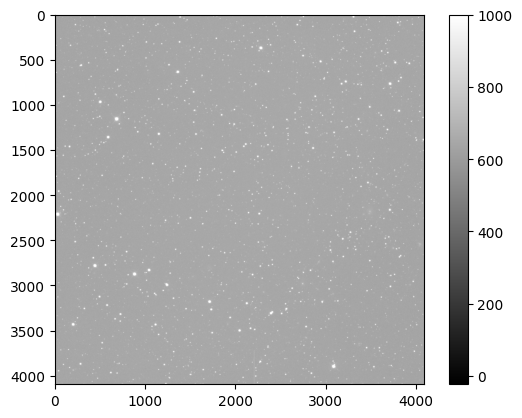

In [10]:
img = ccdp.CCDData.read('data/science_R/36.fits', unit='adu')
plt.imshow(img, vmin = -23, vmax = 1000,cmap='gray')
plt.colorbar()

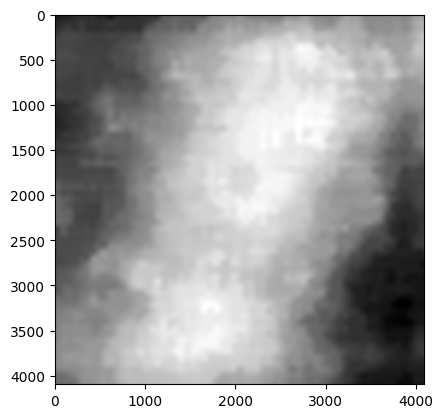

In [11]:
background = bg.Background2D(img, box_size= 65, filter_size = 5, bkg_estimator=MedianBackground())
mean = background.background_median
rms = background.background_rms_median

plt.imshow(np.asarray(background.background), cmap='gray')
plt.show()

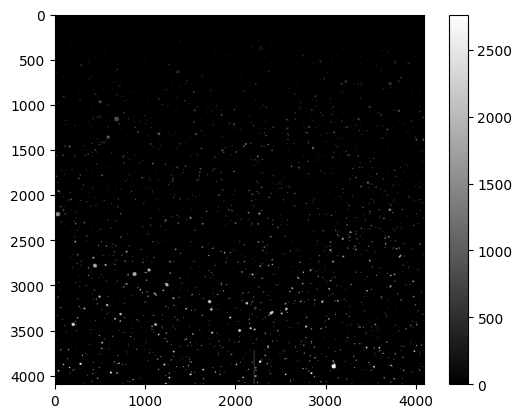

In [12]:
threshold = background.background + rms * 2

kernel = make_2dgaussian_kernel(3,3)
convolved_data = convolve(img, kernel)

segment_map = detect_sources(convolved_data * u.adu, threshold, npixels=5)
plt.imshow(segment_map, cmap='gray')
plt.colorbar()
plt.show()


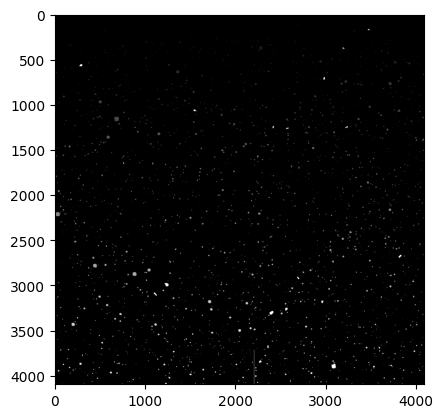

In [13]:
segm_deblend = deblend_sources(convolved_data, segment_map,
                               npixels = 25, nlevels = 32, contrast = 0.001,
                               progress_bar = True)

plt.imshow(segm_deblend, cmap='gray')

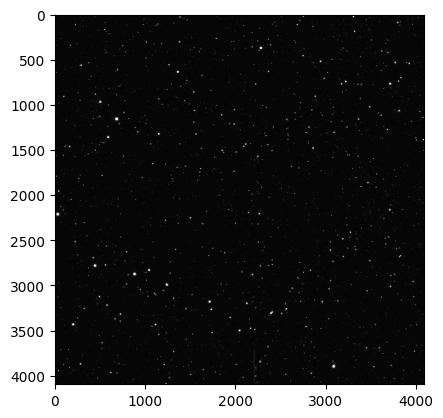

In [15]:
subtracted_background = img - background.background
plt.imshow(subtracted_background.data, cmap = 'gray', vmin = -23, vmax = 1000)

### Pixel values to RA and Dec

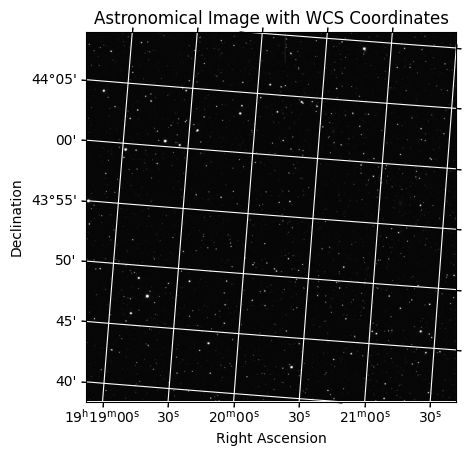

In [8]:
#Using Astrometry.net's WCS file to change pixel position to Ra and Dec
wcs_file = 'data/V1/wcs.fits'

wcs_header = fits.getheader(wcs_file, ext=0)
wcs = WCS(wcs_header)

fig = plt.figure()

ax = fig.add_subplot(1, 1, 1, projection=wcs)

ax.imshow(subtracted_background.data, origin='lower', cmap='gray', vmin = -23, vmax = 1000)

ax.coords.grid(True, color='white', ls='solid')
ax.set_xlabel('Right Ascension')
ax.set_ylabel('Declination')

plt.title('Astronomical Image with WCS Coordinates')
plt.show()

In [17]:
rms_array = background.background_rms
error = calc_total_error(np.array(subtracted_background), np.asarray(rms_array), 2.2)

source_catalog = SourceCatalog(data = np.asarray(subtracted_background), segment_img= segm_deblend, convolved_data = np.array(convolved_data), error = np.asarray(error), wcs= wcs)

image_table = source_catalog.to_table()

### Parse SIMBAD CDS, galaxy data in Abell 2319

In [3]:
#XMASS telescope data on all the galaxies it's recorded in the cluster
filename = 'data/simbad.txt'
galaxy_table = ascii.read(filename, format='csv')

print(f"Table length {len(galaxy_table)}.")
print("Column names:", galaxy_table.colnames)

Table length 317.
Column names: ['#', 'obj_tags', 'obj_count', 'raw_id', 'identifier', 'typ', 'RA', 'Dec', 'Mag_U', 'Mag_B', 'Mag_V', 'Mag_R', 'Mag_I', 'spec_type', 'bib', 'not']


## Matching sources to SIMBAD data

In [51]:
galaxy_coords = SkyCoord(ra=galaxy_table['RA'], dec=galaxy_table['Dec'], unit=(u.hourangle, u.deg))
#print(galaxy_coords)

source_coords = image_table['sky_centroid']
#print(source_coords)

idx, separation_2d, _ = galaxy_coords.match_to_catalog_sky(source_coords) # Calculate the seperation between known galaxy co-ords and image co-ords
#print(separation_2d)

max_separation = 1.5 * u.arcsec # Seperation cannot be more than this for a match
is_match = separation_2d < max_separation
num_matches = np.sum(is_match)
print(f"{num_matches} matches within a {max_separation} radius")


matched_galaxies = galaxy_table[is_match]
matched_sources = image_table[idx[is_match]]
matched_galaxies['separation_arcsec'] = separation_2d[is_match].to(u.arcsec)

final_table = hstack([matched_galaxies, matched_sources], join_type='exact', table_names=['simbad', 'image'])


useful_cols = ['identifier', 'typ', 'separation_arcsec', 'kron_flux', 'segment_flux', 'RA', 'Dec']
final_cols = [c for c in useful_cols if c in final_table.colnames]
final_table[final_cols].pprint_all()


18 matches within a 1.5 arcsec radius
       identifier       typ separation_arcsec       kron_flux          segment_flux             RA                 Dec        
                                  arcsec                                                                                      
----------------------- --- ------------------ ------------------- ------------------- ------------------- -------------------
2MASX J19192555+4405063 GiC 1.4230415704971517  27724.628213690994   1520.085599588394 19 19 25.5938951712 +44 05 06.239269140
2MASX J19192570+4342463 GiC 0.4893986735587412  278.03752336141883   308.4101326511693        19 19 25.708        +43 42 46.34
2MASX J19194300+4405083 GiC 1.4734344771778907 -1501.2737547510014  -1156.779420770631 19 19 43.0141404888 +44 05 07.962425592
2MASX J19200066+4405095 GiC 0.6937016374867457   27683.61956822782  1968.5507568777189 19 20 00.6877052016 +44 05 09.992713380
2MASX J19201015+4344496 GiC 1.4033752927807022   59880.67861963324   428.

### Make a plot showing galaxies identified

<SkyCoord (ICRS): (ra, dec) in deg
    [(289.85664123, 44.08506646), (289.85711667, 43.71287222),
     (289.92922559, 44.08554512), (289.94309699, 44.01643332),
     (290.00286544, 44.08610909), (290.04145075, 43.85607878),
     (290.04150612, 43.79214981), (290.04237376, 43.74707574),
     (290.0791403 , 43.81055892), (290.08000526, 44.14244077),
     (290.08321026, 43.97639078), (290.09866787, 43.84515554),
     (290.13374975, 44.01327461), (290.13577536, 44.01845184),
     (290.13966499, 44.1212949 ), (290.16021832, 44.12137076),
     (290.17085524, 44.14593561), (290.17196612, 43.95469996),
     (290.17598559, 43.94369105), (290.17741385, 43.8810901 ),
     (290.18079747, 44.0472278 ), (290.20562464, 44.05628522),
     (290.20935158, 44.05514489), (290.23220964, 44.08400123),
     (290.24658485, 43.8899321 ), (290.25214965, 44.12668606),
     (290.26323001, 43.89461834), (290.26537673, 43.9524071 ),
     (290.26650258, 43.98809085), (290.27684424, 43.7964212 ),
     (290.2796625 , 

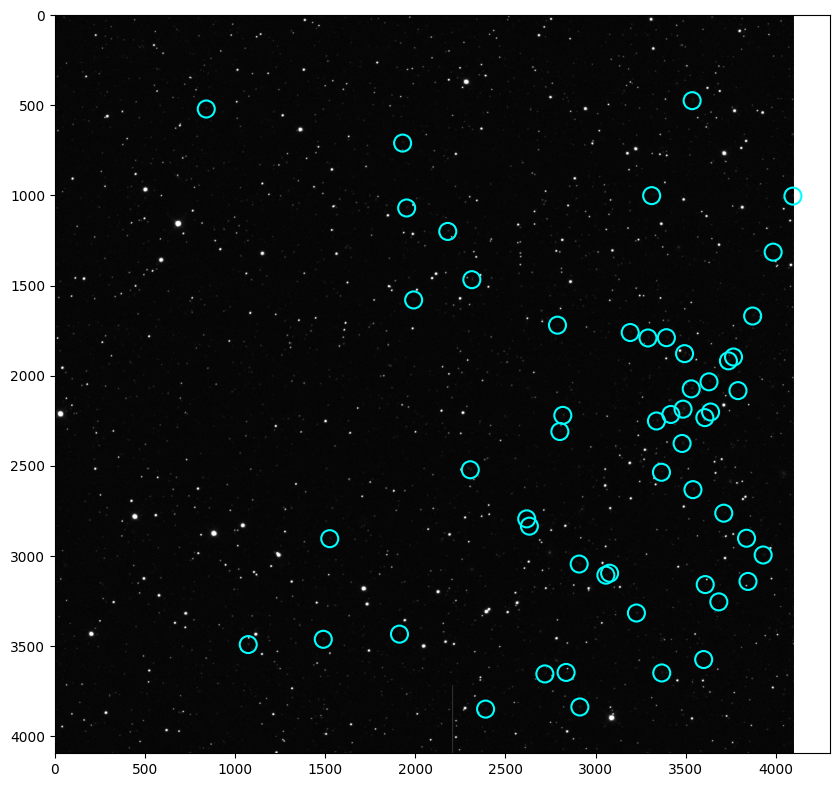

In [22]:
matched_coords = SkyCoord(ra=final_table['RA'],
                          dec=final_table['Dec'],
                          unit=(u.hourangle, u.deg))
print(matched_coords)
ra = matched_coords.ra.deg
dec = matched_coords.dec.deg

pixel_coords = wcs.world_to_pixel_values(ra,dec)
pixel_x = pixel_coords[0]
pixel_y = pixel_coords[1]
#pixel_x = final_table['xcentroid']
#pixel_y = final_table['ycentroid']

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(subtracted_background.data, cmap='gray', vmin = -23, vmax = 1000)
ax.scatter(pixel_x, pixel_y, marker='o', s=150, facecolors='none', edgecolors='cyan', lw=1.5, label='Matched SIMBAD Galaxies')
plt.show()

### Retrieve recessional velocities of identified galaxies from SIMBAD

In [92]:
identifiers = final_table['identifier']
custom_simbad = Simbad()
custom_simbad.add_votable_fields('main_id')
custom_simbad.add_votable_fields('velocity')
redshift_results = custom_simbad.query_objects(identifiers)




### Next time:
- Combine the science frames to get a better version of the image, hopefully increasing matched sources
- Then find absolute mags and zero point for later analysis

# 20/11/25

### To do:
- Combined the science frames for cleaner data
- Start further analysis for mass luminosity relations

### Notes:
- Combining frames using a mean cleans out any issues from cosmic rays etc
- Sources have increased hugely, combining frames has helped a lot to get better flux measurements
- We're using kron flux because it is better for extended sources
- Big change, we will get telescope time today, we want to retake Abell image in R to carry on but hopefully this will improve our data as we should be able to image it more centerally, and we will have darks that fit our data. It should just be repasting and rerunning old code to analyse this.

### Science Frame Combination

In [5]:
files = sorted(glob.glob('data/V1/science_R/*.fits'))
output_stack = 'stacked_deep.fits'

# Open a reference file to start and base all other combination
ref_fn = files[0]
with fits.open(ref_fn) as hdul:
    ref_hdr = hdul[0].header.copy()
    ref_shape = hdul[0].data.shape

frames = []

for i, fn in enumerate(files):
    print(f"{i+1}/{len(files)} {fn}")

    with fits.open(fn) as hdul:
        hdr = hdul[0].header
        img = hdul[0].data.astype(float)

    # Makes sure all data scaled to same amount for based on header data
    bzero = hdr.get('BZERO', 0.0)
    bscale = hdr.get('BSCALE', 1.0)
    pedestal = hdr.get('PEDESTAL', 0.0)
    img = (img * bscale + bzero) - pedestal

    # Background subtract each image before combination
    background = bg.Background2D(img, box_size= 65, filter_size = 5, bkg_estimator=MedianBackground())
    subtracted_background = img - background.background

    frames.append(subtracted_background)

cube = np.stack(frames, axis=0)

# Use sigma clipping and mean combination to avoid issues like cosmic rays
clipped = sigma_clip(cube, sigma=3.0, axis=0,
                        maxiters=4, masked=False)
combined = np.nanmean(clipped, axis=0)
combined = combined * len(frames)


#fits.writeto(output_stack, combined.astype(np.float32), out_hdr, overwrite=True)

1/5 data/V1/science_R\36.fits
2/5 data/V1/science_R\37.fits
3/5 data/V1/science_R\38.fits
4/5 data/V1/science_R\39.fits
5/5 data/V1/science_R\40.fits


### Combined Science Frames Source Matching, repeat of previous code

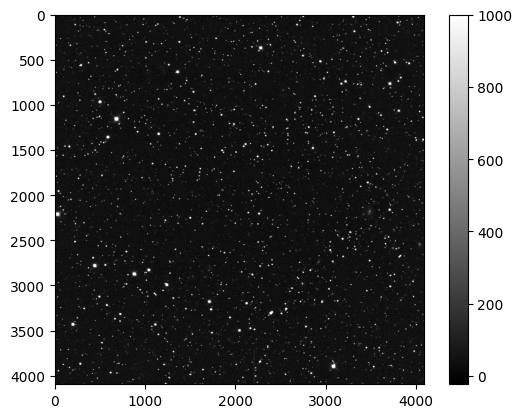

In [141]:
plt.imshow(combined, cmap ='gray', vmin = -23, vmax = 1000)
plt.colorbar()

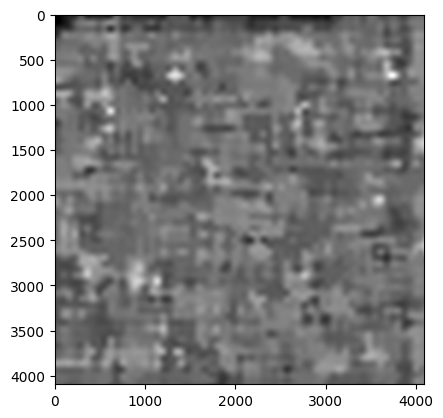

In [142]:
background = bg.Background2D(combined, box_size= 65, filter_size = 5, bkg_estimator=MedianBackground())
mean = background.background_median
rms = background.background_rms_median

plt.imshow(np.asarray(background.background), cmap='gray')

In [143]:
threshold = background.background + rms * 2

kernel = make_2dgaussian_kernel(3,3)
convolved_data = convolve(combined, kernel)

segment_map = detect_sources(convolved_data * u.adu, threshold * u.adu, npixels=5)

segm_deblend = deblend_sources(convolved_data, segment_map,
                               npixels = 25, nlevels = 32, contrast = 0.001,
                               progress_bar = True)

In [144]:
wcs_file = 'data/V1/wcs.fits'

wcs_header = fits.getheader(wcs_file, ext=0)
wcs = WCS(wcs_header)

In [145]:
rms_array = background.background_rms
error = calc_total_error(np.array(subtracted_background), np.asarray(rms_array), 2.2)

source_catalog = SourceCatalog(data = np.asarray(subtracted_background), segment_img= segm_deblend, convolved_data = np.array(convolved_data), error = np.asarray(error), wcs= wcs)

image_table = source_catalog.to_table()

In [146]:
galaxy_coords = SkyCoord(ra=galaxy_table['RA'], dec=galaxy_table['Dec'], unit=(u.hourangle, u.deg))

source_coords = image_table['sky_centroid']

idx, separation_2d, _ = galaxy_coords.match_to_catalog_sky(source_coords)

max_separation = 1.5 * u.arcsec
is_match = separation_2d < max_separation
num_matches = np.sum(is_match)
print(f"{num_matches} matches within a {max_separation} radius")


matched_galaxies = galaxy_table[is_match]
matched_sources = image_table[idx[is_match]]
matched_galaxies['separation_arcsec'] = separation_2d[is_match].to(u.arcsec)

final_table = hstack([matched_galaxies, matched_sources], join_type='exact', table_names=['simbad', 'image'])


useful_cols = ['identifier', 'typ', 'separation_arcsec', 'kron_flux', 'segment_flux', 'RA', 'Dec']
final_cols = [c for c in useful_cols if c in final_table.colnames]
final_table[final_cols].pprint_all()

48 matches within a 1.5 arcsec radius
       identifier       typ separation_arcsec      kron_flux         segment_flux             RA                 Dec        
                                  arcsec                                                                                    
----------------------- --- ------------------ ------------------ ------------------ ------------------- -------------------
2MASX J19192555+4405063 GiC 1.1637033759149713  26471.47132027588 12123.261907190432 19 19 25.5938951712 +44 05 06.239269140
2MASX J19194300+4405083 GiC  1.077439391801862 10523.853496766566  5147.872709525502 19 19 43.0141404888 +44 05 07.962425592
2MASX J19194633+4400593 GiC 0.9420876997477715  13968.91872937579 2946.8252499738783 19 19 46.3432786848 +44 00 59.159961396
2MASX J19200066+4405095 GiC 1.0698907756218599 15493.087118195263  4506.009833634024 19 20 00.6877052016 +44 05 09.992713380
2MASX J19200996+4351216 GiC 0.9634941789230654  8897.325453674304  2063.058544975338 19

<SkyCoord (ICRS): (ra, dec) in deg
    [(289.85664123, 44.08506646), (289.92922559, 44.08554512),
     (289.94309699, 44.01643332), (290.00286544, 44.08610909),
     (290.04145075, 43.85607878), (290.04150612, 43.79214981),
     (290.04237376, 43.74707574), (290.0791403 , 43.81055892),
     (290.08321026, 43.97639078), (290.09866787, 43.84515554),
     (290.13374975, 44.01327461), (290.13577536, 44.01845184),
     (290.16021832, 44.12137076), (290.17196612, 43.95469996),
     (290.17598559, 43.94369105), (290.17741385, 43.8810901 ),
     (290.18079747, 44.0472278 ), (290.20562464, 44.05628522),
     (290.20935158, 44.05514489), (290.23220964, 44.08400123),
     (290.24658485, 43.8899321 ), (290.26323001, 43.89461834),
     (290.26537673, 43.9524071 ), (290.26650258, 43.98809085),
     (290.27684424, 43.7964212 ), (290.2796625 , 43.94865   ),
     (290.28088562, 43.89536321), (290.28139117, 43.74314653),
     (290.2883625 , 43.96925   ), (290.29175103, 43.94559004),
     (290.29503656, 

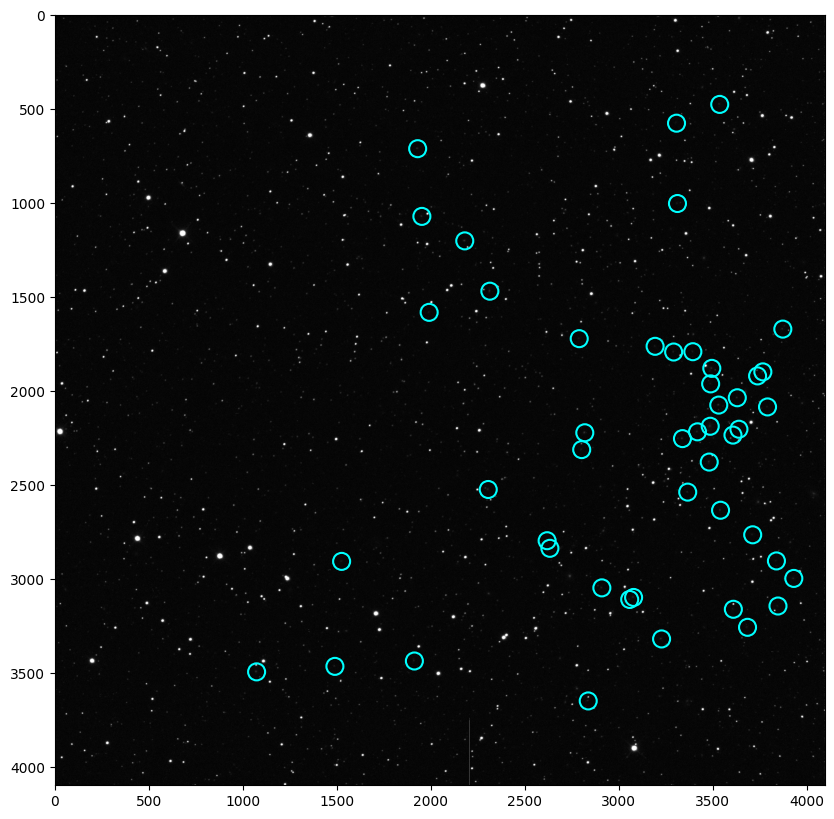

In [147]:
matched_coords = SkyCoord(ra=final_table['RA'],
                          dec=final_table['Dec'],
                          unit=(u.hourangle, u.deg))
print(matched_coords)
ra = matched_coords.ra.deg
dec = matched_coords.dec.deg

pixel_coords = wcs.world_to_pixel_values(ra,dec)
pixel_x = pixel_coords[0]
pixel_y = pixel_coords[1]

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(subtracted_background.data, cmap='gray', vmin = -23, vmax = 1000)
ax.scatter(pixel_x, pixel_y, marker='o', s=150, facecolors='none', edgecolors='cyan', lw=1.5, label='Matched SIMBAD Galaxies')
plt.show()

### Finding Absolute Magnitude

In [148]:
# Add all redshifts and radial velocities for matched galaxies from SIMBAD data
identifiers = final_table['identifier']
custom_simbad = Simbad()
custom_simbad.add_votable_fields('main_id')
custom_simbad. add_votable_fields('velocity')
redshift_results = custom_simbad.query_objects(identifiers)

final_table['redshift'] = redshift_results['rvz_redshift']
final_table['radial_velocity'] = redshift_results['rvz_radvel']

final_table['identifier', 'redshift', 'radial_velocity', 'kron_flux']. pprint_all()

       identifier       redshift  radial_velocity       kron_flux     
                                       km / s                         
----------------------- -------- ------------------ ------------------
2MASX J19192555+4405063 0.051772 15119.593567830923  26471.47132027588
2MASX J19194300+4405083   0.0625 18152.570851376146 10523.853496766566
2MASX J19194633+4400593 0.051876 15149.160260435398  13968.91872937579
2MASX J19200066+4405095 0.058634 17063.531274748108 15493.087118195263
2MASX J19200996+4351216 0.054391  15863.18268356255  8897.325453674304
2MASX J19200996+4347316 0.057416 16719.505378819755  20724.25658346833
2MASX J19201015+4344496 0.052893  15438.11878770817 16592.104071584403
    NVSS J192017+434851 0.064635 18752.092813427986  26616.26203967811
2MASX J19201995+4358346 0.061005 17731.960253086163 15970.948731786197
2MASX J19202364+4350426 0.057523 16749.745343360646 24954.990816906004
2MASX J19203208+4400481 0.088658 25405.017408255993 13976.551217627995
2MASS 

In [149]:
# Leo has found the zero point in his code
zeropoint = 25.0

# Use ZP, distance from redshifts and kron flux to find absolute mag
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
flux = final_table['kron_flux'].value

redshift = np.array(final_table['redshift']).astype(float)

app_mag = -2.5 * np.log10(flux) + zeropoint

dist_lum = cosmo.luminosity_distance(redshift).to(u.pc).value
dist_mod = 5 * np.log10(dist_lum / 10)
abs_mag = app_mag - dist_mod

final_table['app_mag_R'] = app_mag
final_table['abs_mag_R'] = abs_mag

final_table['identifier', 'redshift', 'app_mag_R', 'abs_mag_R'].pprint_all()


       identifier       redshift     app_mag_R           abs_mag_R     
----------------------- -------- ------------------ -------------------
2MASX J19192555+4405063 0.051772 13.943054798378785 -22.869928338458212
2MASX J19194300+4405083   0.0625 14.944563015963348 -22.293953404067828
2MASX J19194633+4400593 0.051876 14.637093023375868 -22.180410047621194
2MASX J19200066+4405095 0.058634 14.524655092655888 -22.569253521034316
2MASX J19200996+4351216 0.054391 15.126851307902772 -21.797370528270772
2MASX J19200996+4347316 0.057416 14.208802598565235 -22.837639933955955
2MASX J19201015+4344496 0.052893 14.450246342242172 -22.411000544908397
    NVSS J192017+434851 0.064635 13.937132341117355 -23.377597421831048
2MASX J19201995+4358346 0.061005  14.49167321110318 -22.691971254435867
2MASX J19202364+4350426 0.057523  14.00710646403059  -23.04354460491787
2MASX J19203208+4400481 0.088658  14.63649994914598 -23.400645149904385
2MASS J19203259+4401066 0.048077 15.654853408320346 -20.99156179

### Next steps:
- Will probably have to repeat all previous code with the new data, but that is just copy/ paste
- If it goes well should be able to move on to mass luminosity relation
- We will need to recalculate ZP

# 25/11/25

### To do:
- Get all new data up to standard of old data before
- Maybe start further analysis if time permits

### Notes:
- All older data is now designated as V1 and all new is called V2, changes made to previous code to fix this
- I don't think we'll be able to use the older data as it's taken form 2017 and our telescope has changed but that should not be an issue, we'll focus entirely on the R-band as that is what we plan to use. Also new data is much better due to more frames and probably more cluster centred.
- Combination now has to be done using the median method, this should still be fine for data cleaning assuming there is no major issues with our science frames. This was due to data limits on my laptop, I couldn't allocate enough storage to do the computation.
- Increased seperation filter but added an ellipticity filter to confirm we are seeing galaxies still
- Lots more galaxies found though, definitely helping with more frames and looking more centerally

### Using V2 Data, method is same for previous older data, so see earlier code

In [9]:
raw_data = Path('data/V2/bias')

calibrated_biases = glob.glob(str(raw_data / '*.fit*'))

combined_bias = ccdp.combine(calibrated_biases,
                             method='average',
                             mem_limit=350e6,
                             unit='adu'
                            )

combined_bias.meta['combined'] = True
combined_bias.write(raw_data / 'combined_bias.fit', overwrite=True)

['data\\V2\\bias\\Bias_Entered Coordinates_0.000secs_R_00002126.fit', 'data\\V2\\bias\\Bias_Entered Coordinates_0.000secs_R_00002127.fit', 'data\\V2\\bias\\Bias_Entered Coordinates_0.000secs_R_00002128.fit', 'data\\V2\\bias\\Bias_Entered Coordinates_0.000secs_R_00002129.fit', 'data\\V2\\bias\\Bias_Entered Coordinates_0.000secs_R_00002130.fit', 'data\\V2\\bias\\Bias_Entered Coordinates_0.000secs_R_00002131.fit', 'data\\V2\\bias\\Bias_Entered Coordinates_0.000secs_R_00002132.fit', 'data\\V2\\bias\\Bias_Entered Coordinates_0.000secs_R_00002133.fit', 'data\\V2\\bias\\Bias_Entered Coordinates_0.000secs_R_00002134.fit', 'data\\V2\\bias\\Bias_Entered Coordinates_0.000secs_R_00002135.fit']


Set OBSGEO-Y to  -131185.767 from OBSGEO-[LBH].
Set OBSGEO-Z to  5055549.706 from OBSGEO-[LBH]'. [astropy.wcs.wcs]


INFO: splitting each image into 22 chunks to limit memory usage to 350000000.0 bytes. [ccdproc.combiner]


In [11]:
path_dark_raw = 'data/V2/darks'
combined_bias = astropy.nddata.CCDData.read('data/V2/bias/combined_bias.fit', unit='adu')

for file_path in glob.glob(os.path.join(path_dark_raw,'*.fit')):
    ccd = ccdp.CCDData.read(file_path, unit='adu')
    ccd = ccdp.subtract_bias(ccd, combined_bias)
    file_name = os.path.basename(file_path)
    ccd.write('data/V2/darks/bias_subtracted_' + file_name, overwrite = True)

INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


In [15]:
path_subtracted_dark_data = Path('data/V2/darks')

dark_file_paths = glob.glob(str(path_subtracted_dark_data / 'bias_subtracted_*.fit'))

combined_darks = ccdp.combine(dark_file_paths,
                             method='median',
                             mem_limit=350e6,
                             unit='adu'
                            )

combined_darks.meta['combined'] = True
combined_darks.write('data/V2/darks/combined_darks.fit', overwrite=True)

INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: splitting each image into 32 chunks to limit memory usage to 350000000.0 bytes. [ccdproc.combiner]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the uni

In [16]:
combined_bias = ccdp.CCDData.read('data/V2/bias/combined_bias.fit', unit='adu')
combined_darks = ccdp.CCDData.read('data/V2/darks/combined_darks.fit', unit='adu')

seconds_unit = u.s

for file_path in glob.glob(os.path.join('data/V2/flat_R/*.fit')):
    ccd = ccdp.CCDData.read(file_path, unit='adu')
    ccd = ccdp.subtract_bias(ccd, combined_bias)
    ccd = ccdp.subtract_dark(ccd, combined_darks, exposure_time='EXPTIME', exposure_unit = seconds_unit)
    ccd_mean =  np.mean(ccd)
    ccd = normalise(ccd, ccd_mean)
    file_name = os.path.basename(file_path)
    ccd.write('data/V2/flat_R/cleaned_' + file_name, overwrite = True)

INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


In [18]:
calibrated_flats = glob.glob('data/V2/flat_R/*.fit')

combined_flats = ccdp.combine(calibrated_flats,
                             method='median',
                             mem_limit=350e6,
                             unit = 'adu'
                            )

combined_flats.meta['combined'] = True
combined_flats.write('data/V2/flat_R/combined_flats_R.fit', overwrite = True)

INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: splitting each image into 16 chunks to limit memory usage to 350000000.0 bytes. [ccdproc.combiner]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the uni

In [21]:
combined_dark = ccdp.CCDData.read('data/V2/darks/combined_darks.fit', unit='adu')
combined_bias = ccdp.CCDData.read('data/V2/bias/combined_bias.fit', unit='adu')
combined_flat = ccdp.CCDData.read('data/V2/flat_R/combined_flats_R.fit', unit='adu')
cleaned_science_path = Path('data/V2/science_R')

i = 1
for file_path in cleaned_science_path.glob('*.fit'):
    ccd = ccdp.CCDData.read(file_path, unit='adu')
    ccd = ccdp.subtract_bias(ccd, combined_bias)
    ccd = ccdp.subtract_dark(ccd, combined_dark, exposure_time='EXPTIME', exposure_unit = seconds_unit, scale = True)
    ccd = ccdp.ccd_process(ccd, master_flat = combined_flat, exposure_key='EXPTIME', exposure_unit = seconds_unit)
    ccd.write(cleaned_science_path / f'{i}.fits', overwrite = True)
    i += 1

INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


In [5]:
wcs_file = 'data/V2/wcs.fits'

wcs_header = fits.getheader(wcs_file, ext=0)
wcs = WCS(wcs_header)

In [7]:
files = sorted(glob.glob('data/V2/science_R/*.fits'))
output_stack = 'stacked_deep.fits'

ref_fn = files[0]
with fits.open(ref_fn) as hdul:
    ref_hdr = hdul[0].header.copy()
    ref_raw = hdul[0].data.astype(float)
    bzero = hdul[0].header.get('BZERO', 0.0)
    bscale = hdul[0].header.get('BSCALE', 1.0)
    pedestal = hdul[0].header.get('PEDESTAL', 0.0)
    ref_img = (ref_raw * bscale + bzero) - pedestal

ref_background = bg.Background2D(ref_img, box_size=65, filter_size=5, bkg_estimator=MedianBackground())
ref_sub = ref_img - ref_background.background
ny, nx = ref_sub.shape

cube = np.memmap('temp_cube.dat', dtype='float32', mode='w+', shape=(len(files), ny, nx))

frames = []

for i, fn in enumerate(files):
    print(f"{i+1}/{len(files)} {fn}")

    with fits.open(fn) as hdul:
        hdr = hdul[0].header
        img = hdul[0].data.astype(float)

    bzero = hdr.get('BZERO', 0.0)
    bscale = hdr.get('BSCALE', 1.0)
    pedestal = hdr.get('PEDESTAL', 0.0)
    img = (img * bscale + bzero) - pedestal

    background = bg.Background2D(img, box_size= 65, filter_size = 5, bkg_estimator=MedianBackground())
    subtracted_background = img - background.background

    src = np.nan_to_num(subtracted_background, nan=0.0, posinf=0.0, neginf=0.0)
    tgt = np.nan_to_num(ref_sub, nan=0.0, posinf=0.0, neginf=0.0)

    res = aa.register(src, tgt)
    if isinstance(res, tuple):
        registered_img = res[0]
    else:
        registered_img = res

    registered = np.asarray(registered_img, dtype=np.float32)

    frames.append(registered)

cube = np.stack(frames, axis=0)

combined = np.nanmedian(cube, axis=0)
#combined = combined * len(frames)

1/10 data/V2/science_R\1.fits
2/10 data/V2/science_R\10.fits
3/10 data/V2/science_R\2.fits
4/10 data/V2/science_R\3.fits
5/10 data/V2/science_R\4.fits
6/10 data/V2/science_R\5.fits
7/10 data/V2/science_R\6.fits
8/10 data/V2/science_R\7.fits
9/10 data/V2/science_R\8.fits
10/10 data/V2/science_R\9.fits


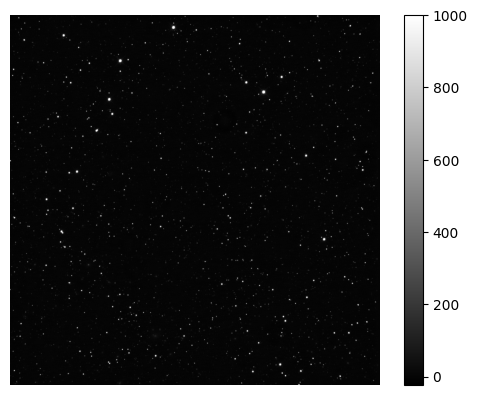

In [8]:
plt.imshow(combined, cmap ='gray', vmin = -23, vmax = 1000)
plt.colorbar()
plt.axis('off')
plt.savefig("Combined.png", bbox_inches='tight')

In [9]:
fits.writeto('combined_image.fits', combined, header=wcs. to_header(), overwrite=True)

In [10]:
background = bg.Background2D(combined, box_size= 65, filter_size = 5, bkg_estimator=MedianBackground())
mean = background.background_median
rms = background.background_rms_median

threshold = background.background + rms * 2

kernel = make_2dgaussian_kernel(3, 3)
convolved_data = convolve(combined, kernel)

segment_map = detect_sources(convolved_data * u.adu, threshold * u.adu, npixels=5)

segm_deblend = deblend_sources(convolved_data, segment_map,
                               npixels=25, nlevels=32, contrast=0.001,
                               progress_bar=True)

In [11]:
rms_array = background.background_rms
error = calc_total_error(np. array(combined), np.asarray(rms_array), 2.2)

source_catalog = SourceCatalog(data = np.asarray(combined), segment_img= segm_deblend, convolved_data = np.array(convolved_data), error = np.asarray(error), wcs= wcs)

image_table = source_catalog.to_table()

## Match observed sources to galaxies we know are in the cluster

In [22]:
galaxy_coords = SkyCoord(ra=galaxy_table['RA'], dec=galaxy_table['Dec'], unit=(u.hourangle, u.deg)) # Sky co-ords of galaxies from SIMBAD dataset

source_coords = image_table['sky_centroid']

# Match sources in source catalogue to galaxies
idx, separation_2d, _ = galaxy_coords.match_to_catalog_sky(source_coords)

# Filter based on how close positionally
max_separation = 3 * u.arcsec # would do 1.5 but it does not return enough values that we know are in frame
is_match = separation_2d < max_separation
num_matches = np.sum(is_match)
print(f"{num_matches} matches within a {max_separation} radius")

# Filter based on shape, galaxies will be eccentric
semimajor_by_galaxy = image_table['semimajor_sigma'][idx].value
psf_sigma = 1.5
is_extended = semimajor_by_galaxy > psf_sigma
final_mask = is_match & is_extended
print(f"{np. sum(final_mask)} extended sources (likely galaxies)")

matched_galaxies = galaxy_table[final_mask]
matched_sources = image_table[idx[final_mask]]
matched_galaxies['separation_arcsec'] = separation_2d[final_mask].to(u.arcsec)

final_table = hstack([matched_galaxies, matched_sources], join_type='exact', table_names=['simbad', 'image'])


useful_cols = ['identifier', 'typ', 'separation_arcsec', 'kron_flux', 'segment_flux', 'RA', 'Dec']
final_cols = [c for c in useful_cols if c in final_table.colnames]
final_table[final_cols].pprint_all()

72 matches within a 3.0 arcsec radius
72 extended sources (likely galaxies)
       identifier       typ  separation_arcsec      kron_flux         segment_flux             RA                 Dec        
                                   arcsec                                                                                    
----------------------- --- ------------------- ------------------ ------------------ ------------------- -------------------
2MASX J19192555+4405063 GiC  1.4230415658955264 27918.166575446012  19456.35223042965 19 19 25.5938951712 +44 05 06.239269140
2MASX J19192570+4342463 GiC 0.48939867603200055 11047.291503367158  8319.631398200989        19 19 25.708        +43 42 46.34
2MASX J19194300+4405083 GiC  1.4734344796731125  11308.35832692554  7899.303565979004 19 19 43.0141404888 +44 05 07.962425592
2MASX J19194633+4400593 GiC  1.5493384014608882  25201.75650515284 10549.403090953827 19 19 46.3432786848 +44 00 59.159961396
2MASX J19195319+4341555 GiC  1.63425604132

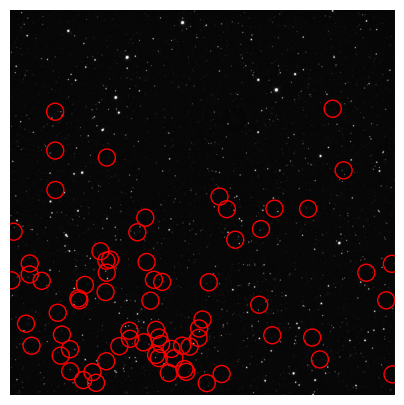

In [23]:
matched_coords = SkyCoord(ra=final_table['RA'],
                          dec=final_table['Dec'],
                          unit=(u.hourangle, u.deg))

ra = matched_coords.ra.deg
dec = matched_coords.dec.deg

pixel_coords = wcs.world_to_pixel_values(ra,dec)
#pixel_x = pixel_coords[0]
#pixel_y = pixel_coords[1]
pixel_x = final_table['xcentroid']
pixel_y = final_table['ycentroid']


fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(subtracted_background.data, cmap='gray', vmin = -23, vmax = 1000)
ax.scatter(pixel_x, pixel_y, marker='o', s=150, facecolors='none', edgecolors='red', lw=1, label='Matched SIMBAD Galaxies')
ax.axis('off')
plt.savefig('identified_combined.png', bbox_inches='tight')
plt.show()

## SIMBAD Query for matched galaxies to get recessional velocities

In [24]:
identifiers = final_table['identifier']
custom_simbad = Simbad()
custom_simbad.add_votable_fields('main_id')
custom_simbad. add_votable_fields('velocity')
redshift_results = custom_simbad.query_objects(identifiers)

final_table['redshift'] = redshift_results['rvz_redshift']
final_table['radial_velocity'] = redshift_results['rvz_radvel']

final_table['identifier', 'redshift', 'radial_velocity', 'kron_flux']. pprint_all()

       identifier       redshift  radial_velocity       kron_flux     
                                       km / s                         
----------------------- -------- ------------------ ------------------
2MASX J19192555+4405063 0.051772 15119.593567830923 27918.166575446012
2MASX J19192570+4342463 0.058697 17081.313732268663 11047.291503367158
2MASX J19194300+4405083   0.0625 18152.570851376146  11308.35832692554
2MASX J19194633+4400593 0.051876 15149.160260435398  25201.75650515284
2MASX J19195319+4341555 0.046262 13548.522656812735    9745.1457472755
2MASX J19200066+4405095 0.058634 17063.531274748108 22566.013531014974
2MASX J19200432+4351576 0.040201 11809.894291803712  5421.123572901164
2MASX J19200996+4351216 0.054391  15863.18268356255 11360.019573043937
2MASX J19200996+4347316 0.057416 16719.505378819755 17789.503428368647
2MASX J19201015+4344496 0.052893  15438.11878770817  18583.46638002213
2MASX J19201346+4357556 0.052743 15395.518882238011 11940.908071589596
    NV

### Next steps:
- Find zero point
- Convert using luminocity relation
- Obtain final result

# 27/11/25

### To do:
- Use Leo's code for zero point to find new zero point for new frames
- Find absolute mag of sources
- Convert to mass using relation
- Use total mass from Leo's virial theorem code to get a final result

### Notes:
- Using basic luminocity relation just relating in terms of solar values, assuming a constant luminocity relation which probably isn't true but we cannot confirm galaxy types due to plane of sight and lack of H-alpha data. Instead we assume that we have caught only the bright R band, larger, older galaxies, which dominate the cluster which will most likely be elliptical Boselli, et al. DOI: 10.1086/500691. We therefore use 3 for the mass luminocity relation, Bell et al. DOI: 10.1086/378847.
- Initial masses are too massive for any observed galaxies we know, there is an issue with the fluxes.
- After a lot of bug fixing we found that the Zero point was being calculated using segment flux rather than kron, fixed by matching reference star to one in source catalogue and using its source flux.
- Demonstrators have suggested using a mass function to account for hidden masses, assuming that our telescope is not good enough to find the fainter galaxies.

## Zero point calculations

In [25]:
# Revised zero point code, take reference stars in frame, match them to likely stars in source catalogue then find an average zero point between them all.

corr_table = Table.read('data/V2/corr_1.fits') # List of reference stars and relation to the frame from astrometry.net

star_ra = np.array(corr_table['field_ra']).astype(float)
star_dec = np.array(corr_table['field_dec']).astype(float)
star_coords = SkyCoord(ra=star_ra, dec=star_dec, unit='deg')

source_coords = image_table['sky_centroid']

idx, sep, _ = star_coords. match_to_catalog_sky(source_coords) #Match reference star co-ords to those in source catalogue

max_sep = 2.0 * u.arcsec
good_match = sep < max_sep

matched_stars = corr_table[good_match]
matched_sources = image_table[idx[good_match]]

ref_mag = np.array(matched_stars['MAG']).astype(float)
kron_flux = np.array(matched_sources['kron_flux']).astype(float)

good = (kron_flux > 0) & (ref_mag > 12) & (ref_mag < 16) # Filter out any wrong bright objects (the galaxies in our frame)
ref_mag = ref_mag[good]
kron_flux = kron_flux[good]

mag_inst = -2.5 * np.log10(kron_flux)

zp_each = ref_mag - mag_inst

# Find average zero point
zeropoint = float(np.median(zp_each))
zp_std = float(np. std(zp_each))

print(f"Zeropoint: {zeropoint} +- {zp_std}")

Zeropoint: 26.812448453980565 +- 0.1116394184416636


## Change apparent magnitudes to absolute magnitudes

In [26]:
zeropoint = 26.81

cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
flux = final_table['kron_flux'].value

redshift = np.array(final_table['redshift']).astype(float)

# Find galaxy sources
app_mag = -2.5 * np.log10(flux) + zeropoint

# Use catalogued redshifts to find distance modulus to change to absolute magnitudes
dist_lum = cosmo.luminosity_distance(redshift).to(u.pc).value
dist_mod = 5 * np.log10(dist_lum / 10)
abs_mag = app_mag - dist_mod

final_table['app_mag_R'] = app_mag
final_table['abs_mag_R'] = abs_mag

final_table['identifier', 'redshift', 'app_mag_R', 'abs_mag_R'].pprint_all()

       identifier       redshift     app_mag_R           abs_mag_R     
----------------------- -------- ------------------ -------------------
2MASX J19192555+4405063 0.051772 15.695282764577017 -21.117700372259982
2MASX J19192570+4342463 0.058697  16.70186046542834 -20.394477373706025
2MASX J19194300+4405083   0.0625  16.67650109628648 -20.562015323744696
2MASX J19194633+4400593 0.051876 15.806422972062947 -21.011080098934116
2MASX J19195319+4341555 0.046262  16.83802915309905  -19.72197075591849
2MASX J19200066+4405095 0.058634 15.926362889456422 -21.167545724233783
2MASX J19200432+4351576 0.040201 17.474776732482233 -18.770711894994626
2MASX J19200996+4351216 0.054391  16.67155230086319 -20.252669535310353
2MASX J19200996+4347316 0.057416 16.184590436328868 -20.861852096192322
2MASX J19201015+4344496 0.052893 16.137183184238218 -20.724063702912353
2MASX J19201346+4357556 0.052743  16.61740661277274  -20.23743975456226
    NVSS J192017+434851 0.064635  15.65069407589402 -21.66403568

## Apply Luminocity Mass Relations

In [27]:
mag_absolute = final_table['abs_mag_R']

M_sun_R = 4.42 # Sun R-band mag
M_L_ratio = 3

L_solar = 10**((M_sun_R - mag_absolute) / 2.5) # Luminocity of our galaxy
M_luminous = M_L_ratio * L_solar # Mass

final_table['L_solar'] = L_solar
final_table['M_luminous'] = M_luminous

final_table['identifier', 'redshift', 'abs_mag_R', 'L_solar', 'M_luminous'].pprint()

       identifier       redshift ...      L_solar           M_luminous    
----------------------- -------- ... ------------------ ------------------
2MASX J19192555+4405063 0.051772 ...  16408925714.43139 49226777143.294174
2MASX J19192570+4342463 0.058697 ...  8429289106.944107  25287867320.83232
2MASX J19194300+4405083   0.0625 ...  9835719379.588575 29507158138.765724
2MASX J19194633+4400593 0.051876 ... 14874145982.924686  44622437948.77406
2MASX J19195319+4341555 0.046262 ...  4537203959.077533 13611611877.232597
2MASX J19200066+4405095 0.058634 ... 17179807359.458162  51539422078.37449
2MASX J19200432+4351576 0.040201 ... 1889229672.2868664 5667689016.8605995
2MASX J19200996+4351216 0.054391 ...  7397207718.054502 22191623154.163506
2MASX J19200996+4347316 0.057416 ... 12964054212.493702  38892162637.48111
2MASX J19201015+4344496 0.052893 ...  11418931853.68435 34256795561.053047
                    ...      ... ...                ...                ...
2MASX J19212126+4354524 0

## Final result using only galaxies in frame

In [28]:
total = sum(final_table['M_luminous'])
print(total)

2582536295636.062


- Assume ICM 15% of gravitating mass, cannot get further data on this as most ICM light is in the X-ray, Diffuse radio emission from the intracluster medium L. Feretti a,* , C. Burigana b , T.A. Enßlin c

In [29]:
full_mass = 1.537017e16
plasma_mass = full_mass*0.15
DARKMATTER = full_mass - plasma_mass - total
print(f"FOUND IT {DARKMATTER}, thats {DARKMATTER/full_mass}")

FOUND IT 1.3062061963704364e+16, thats 0.8498319773759409


## Using a galaxy mass function to account for unseen mass

In [30]:
#We use the Schechter Mass Function GSMF, "Stellar mass functions: methods, systematics and results for the local Universe", MNRAS, 459, 2150–2187, Weigel, Schawinski & Bruderer (2016), intergrating it to find values of unseen mass from faint galaxies
#"Stellar mass functions: methods, systematics and results for the local Universe", van der Burg et al. (2018)

# Parameters
M_star = 10**10.9  # characteristic mass of galaxies
alpha = -1.2       # faint-end slope
phi_star = 1.0     # normalized

# Mass Function
def schechter(M, M_star, alpha, phi_star):
    x = M / M_star
    return phi_star * (x**alpha) * np.exp(-x) / M_star

# Intergration limits, typical galactic masses based on typical mass distribution and results
M_min_model = 1e7
M_max_model = 1e13

M_detection_limit = np. min(M_luminous)

# Total mass based on model
total_integral, _ = quad(lambda M: schechter(M, M_star, alpha, phi_star) * M, M_min_model, M_max_model)
# What we actually see based on telescope limit
observed_integral, _ = quad(lambda M: schechter(M, M_star, alpha, phi_star) * M, M_detection_limit, M_max_model)

mass_correction_factor = total_integral / observed_integral

observed_mass = np.sum(M_luminous)
total_mass_estimate = observed_mass * mass_correction_factor # Correct for unseen luminous mass
print(total_mass_estimate)

2948106655274.0854


## Result accounting for faint galaxies

In [31]:
# Simple revised estimate for dark matter in the galaxy
DARKMATTER = full_mass - plasma_mass - total_mass_estimate
print(f"FOUND IT {DARKMATTER}, thats {DARKMATTER/full_mass}")

FOUND IT 1.3061696393344726e+16, thats 0.8498081929701966


- We have found a proper value of 0.85% dark matter in the cluster which is reasonable for general knowledge about visible to dark matter ratios
- Need to start report, error propagation added and potentially issue with not picking up bright galaxies due to frames not covering the whole cluster

### Next time:
- Start report
- Error propagation
- Account for partial view

# 2/12/25

### To do:
- Think of further fixes
- Include errors
- Do project report

### Notes:
- Decided to focus on report due to time till submission and happy with values. Most likely small changes will be made to code later but for now we are happy with results.
- Started on introduction section for report

### Next time:
- Carry on with report
- Add error propagation and correct for partial survey if possible

# 4/12/25

### To do:
- Account for galaxies not in frame
- Project report
- Include Errors

### Notes:
- Report is going well, at method section